In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

In [2]:
from scipy.constants import elementary_charge as qe, electron_mass as me, epsilon_0 as eps0
from math import pi as pi

In [176]:
omega0 = 1e20
alpha = 0
Vbar = 0.010
beta = 0.033

print(-Vbar/beta)
if alpha != 0:
    print(-1/alpha)

-0.30303030303030304


In [177]:
def trap_frequency(Vtg, omega0, alpha):
    return np.sqrt(omega0**2 * (1 + alpha * Vtg))

def barrier_height(Vtg, Vbar, beta):
    return Vbar + beta * Vtg

def d2(Vtg, omega0, alpha):
    omega = trap_frequency(Vtg, omega0, alpha)
    return (qe / (pi * eps0 * me * omega ** 2)) ** (1/3.)

def d3(Vtg, omega0, alpha):
    omega = trap_frequency(Vtg, omega0, alpha)
    return (2 / 3. * qe / (4 * pi * eps0 * me * omega ** 2)) ** (1/3.)

def V2e_jump(Vtg, omega0, alpha, Vbar, beta):
    distance = d2(Vtg, omega0, alpha)
    omega = trap_frequency(Vtg, omega0, alpha)
    Vb = barrier_height(Vtg, Vbar, beta)
    return 1/2. * (1 / 8. * (me * omega ** 2 * distance ** 2) + qe / (4 * pi * eps0 * distance)) - Vb

def V3e_jump(Vtg, omega0, alpha, Vbar, beta):
    distance = d3(Vtg, omega0, alpha)
    omega = trap_frequency(Vtg, omega0, alpha)
    Vb = barrier_height(Vtg, Vbar, beta)
    return 1/3. * (9 / 8. * (me * omega ** 2 * distance ** 2) + 3 / 2. * qe / (4 * pi * eps0 * distance)) - Vb

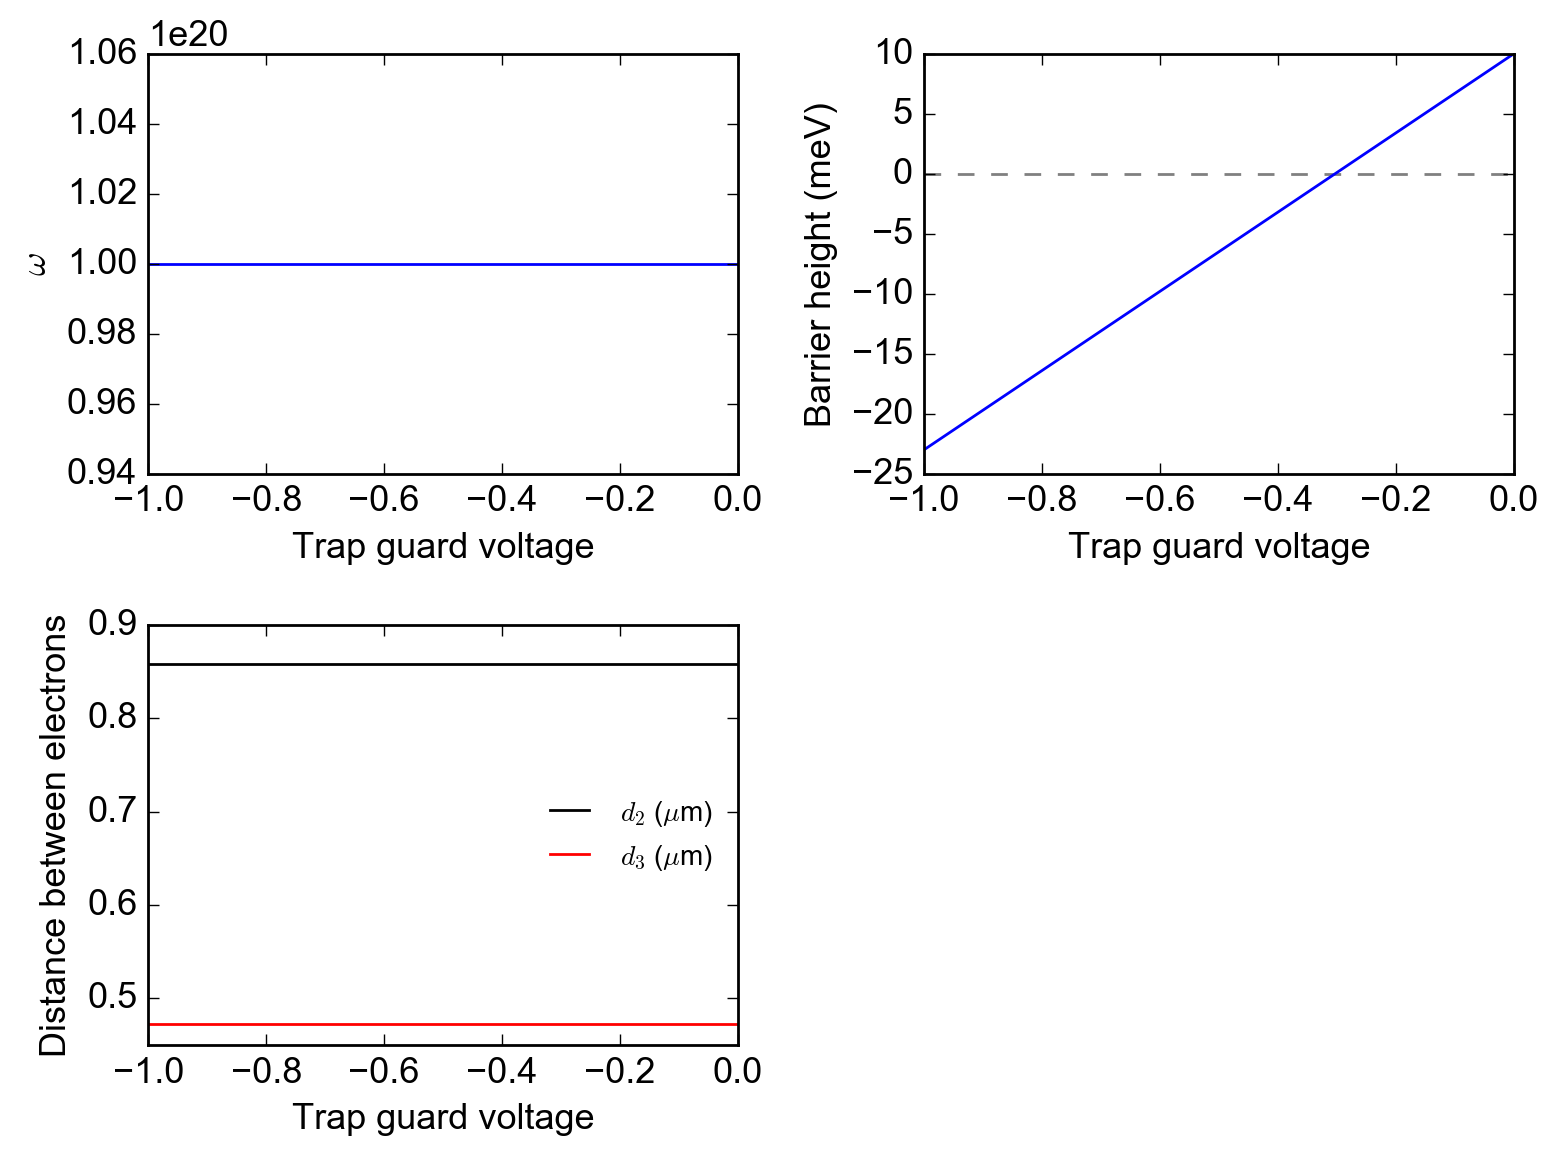

In [178]:
Vtg = np.linspace(-1.0, 0.0, 101)

fig = plt.figure(figsize=(8., 6.))
common.configure_axes(13)
plt.subplot(221)
plt.plot(Vtg, trap_frequency(Vtg, omega0, alpha))
plt.xlabel("Trap guard voltage")
plt.ylabel("$\omega$")

plt.subplot(222)
plt.plot(Vtg, barrier_height(Vtg, Vbar, beta) * 1E3)
plt.hlines(0.00, np.min(Vtg), np.max(Vtg), linestyles="--", color='gray')
plt.ylabel("Barrier height (meV)")
plt.xlabel("Trap guard voltage")

plt.subplot(223)
plt.plot(Vtg, d2(Vtg, omega0, alpha) * 1E6, '-k', label="$d_2$ ($\mu$m)")
plt.ylabel("Distance between electrons")

plt.plot(Vtg, d3(Vtg, omega0, alpha) * 1E6, '-r', label="$d_3$ ($\mu$m)")
plt.xlabel("Trap guard voltage")
plt.legend(loc=0, frameon=False, prop={"size" : 10})

fig.tight_layout()

In [179]:
from scipy.optimize import newton

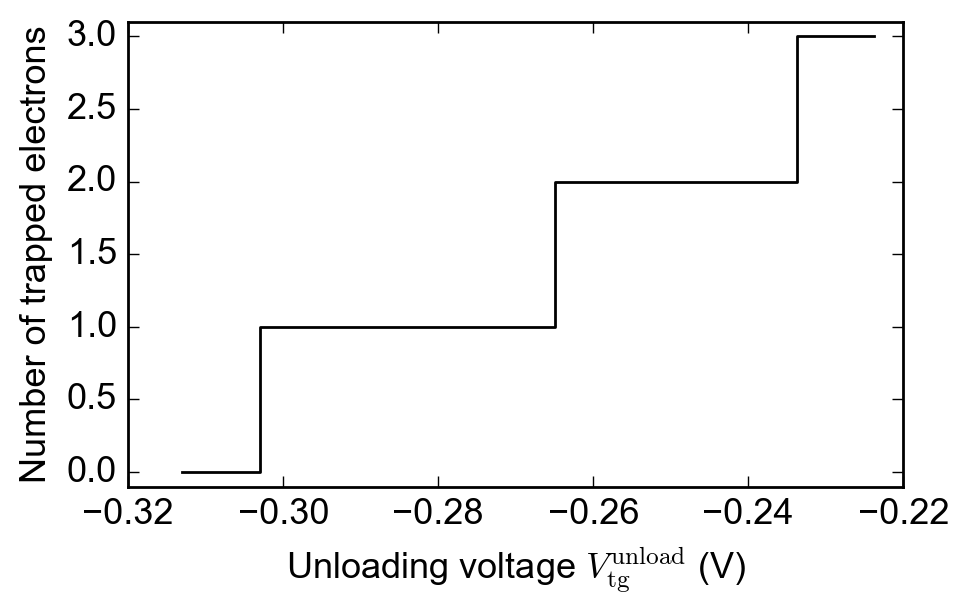

In [180]:
if alpha != 0:
    init_guess = 1/alpha + 0.1
else:
    init_guess = -0.1
    
plt.figure(figsize=(5.,3.))
common.configure_axes(13)
plt.step([-Vbar/beta-0.01, -Vbar/beta, 
          newton(func=V2e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
          newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
          newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta))+0.01], [0, 0, 1, 2, 3], 'k')
plt.ylim(-0.1, 3.1)
# plt.xlim(-1, 0)
plt.ylabel("Number of trapped electrons")
plt.xlabel("Unloading voltage $V_\mathrm{tg}^\mathrm{unload}$ (V)")